In [101]:
import numpy as np
from numpy.linalg import norm
import scipy.spatial as spt
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.path import Path
import concave_hull.lineintersect as li
from concave_hull import *

import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from descartes import PolygonPatch

import netCDF4

In [102]:
def segment(s):
    return ((s[0, 0], s[0, 1]), (s[1, 0], s[1, 1]))

def get_points(ds, down_sample=None):
    latitude_first = ds.variables['latitude_first'][:]
    longitude_first = ds.variables['longitude_first'][:]
    latitude_last = ds.variables['latitude_last'][:]
    longitude_last = ds.variables['longitude_last'][:]
    
    if down_sample is not None:
        latitudes = np.concatenate((latitude_first, ds['latitude'][::down_sample], latitude_last), axis=0)
        longitudes = np.concatenate((longitude_first, ds['longitude'][::down_sample], longitude_last), axis=0)
    else:
        latitudes = np.concatenate((latitude_first, latitude_last), axis=0)
        longitudes = np.concatenate((longitude_first, longitude_last), axis=0)
        
    points = np.transpose(np.array([latitudes, longitudes]))
    return points

# Test with only line endpoints

In [103]:
ds = netCDF4.Dataset('http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/axi547/magnetic_line/GSQP1029MAG.nc')

In [104]:
list(ds.variables)

['line',
 'line_index',
 'flag_subarea',
 'flag_levelling',
 'flag_linetype',
 'fiducial',
 'height',
 'latitude',
 'longitude',
 'mag_awags',
 'mag_mlev',
 'mag_lev',
 'crs',
 'longitude_first',
 'longitude_last',
 'latitude_first',
 'latitude_last',
 'bounding_polygon',
 'survey']

In [105]:
%%time
points = get_points(ds)

CPU times: user 39 ms, sys: 35 µs, total: 39.1 ms
Wall time: 1.41 s


In [106]:
%%time
hull = concaveHull(points, 3)

CPU times: user 5min 11s, sys: 1.03 s, total: 5min 12s
Wall time: 5min 37s


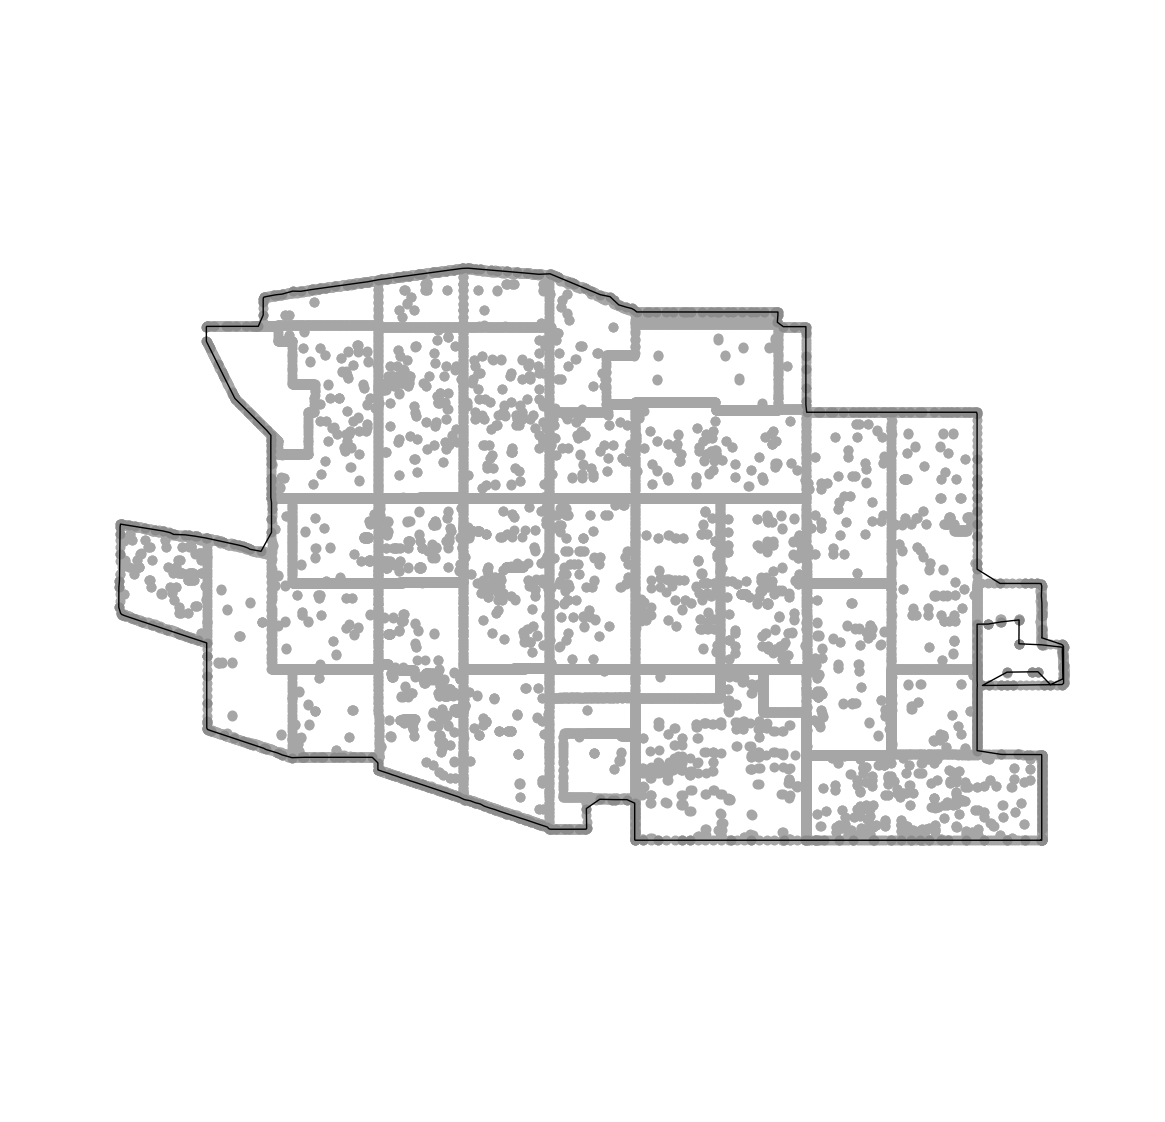

In [107]:
plt.figure(figsize=(20, 20))
plotPath(points, hull)

In [27]:
%%time
hull = concaveHull(points, 20)

CPU times: user 1min 42s, sys: 39.9 ms, total: 1min 42s
Wall time: 1min 43s


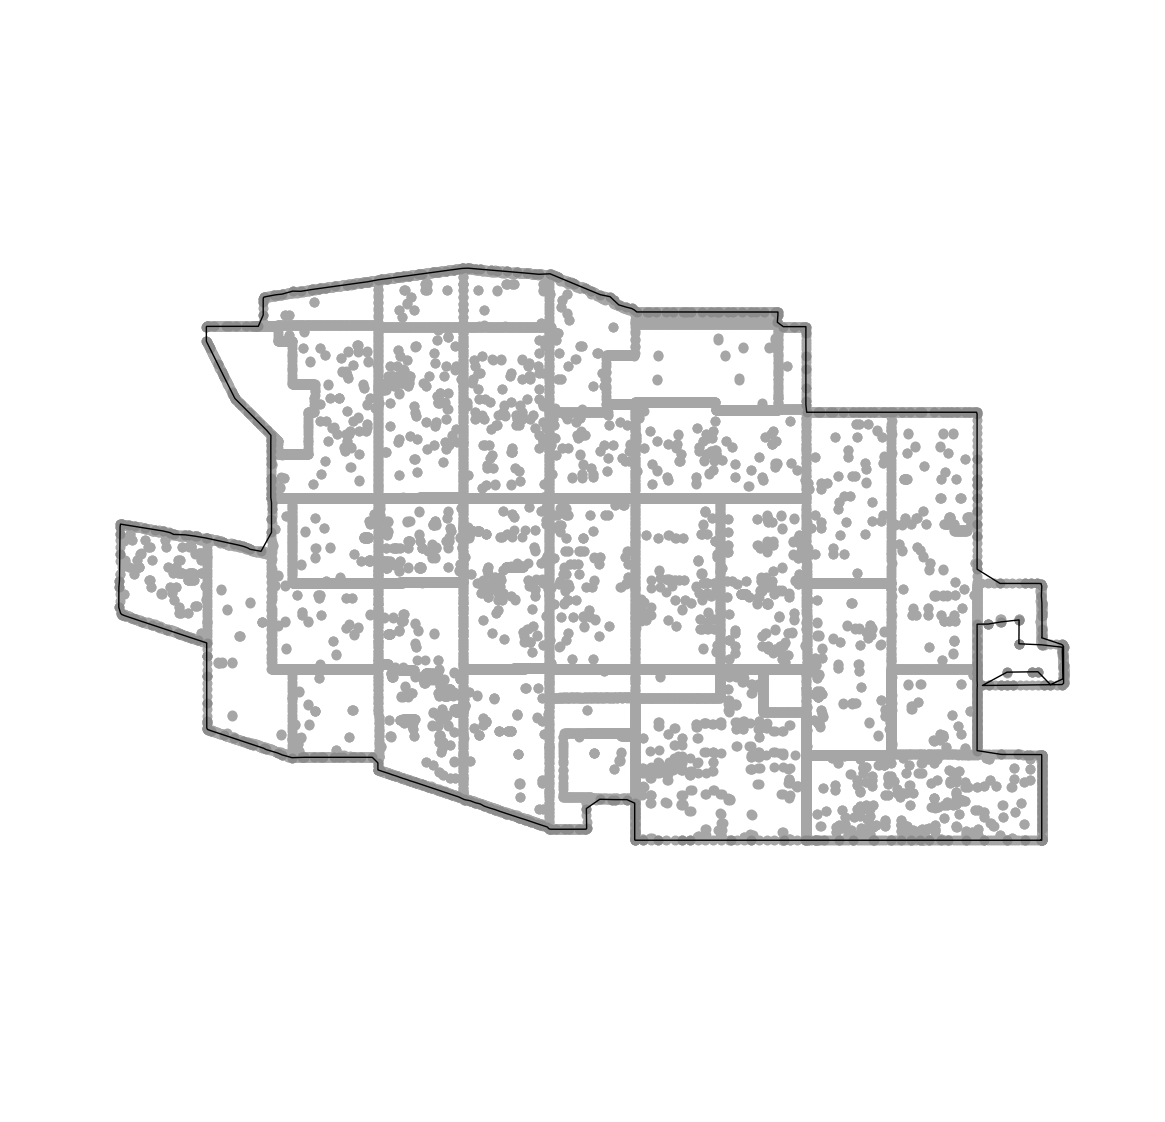

In [28]:
plt.figure(figsize=(20, 20))
plotPath(points, hull)

In [12]:
%%time
points = get_points(ds, 100000)

CPU times: user 8.11 ms, sys: 9 µs, total: 8.12 ms
Wall time: 7.35 ms


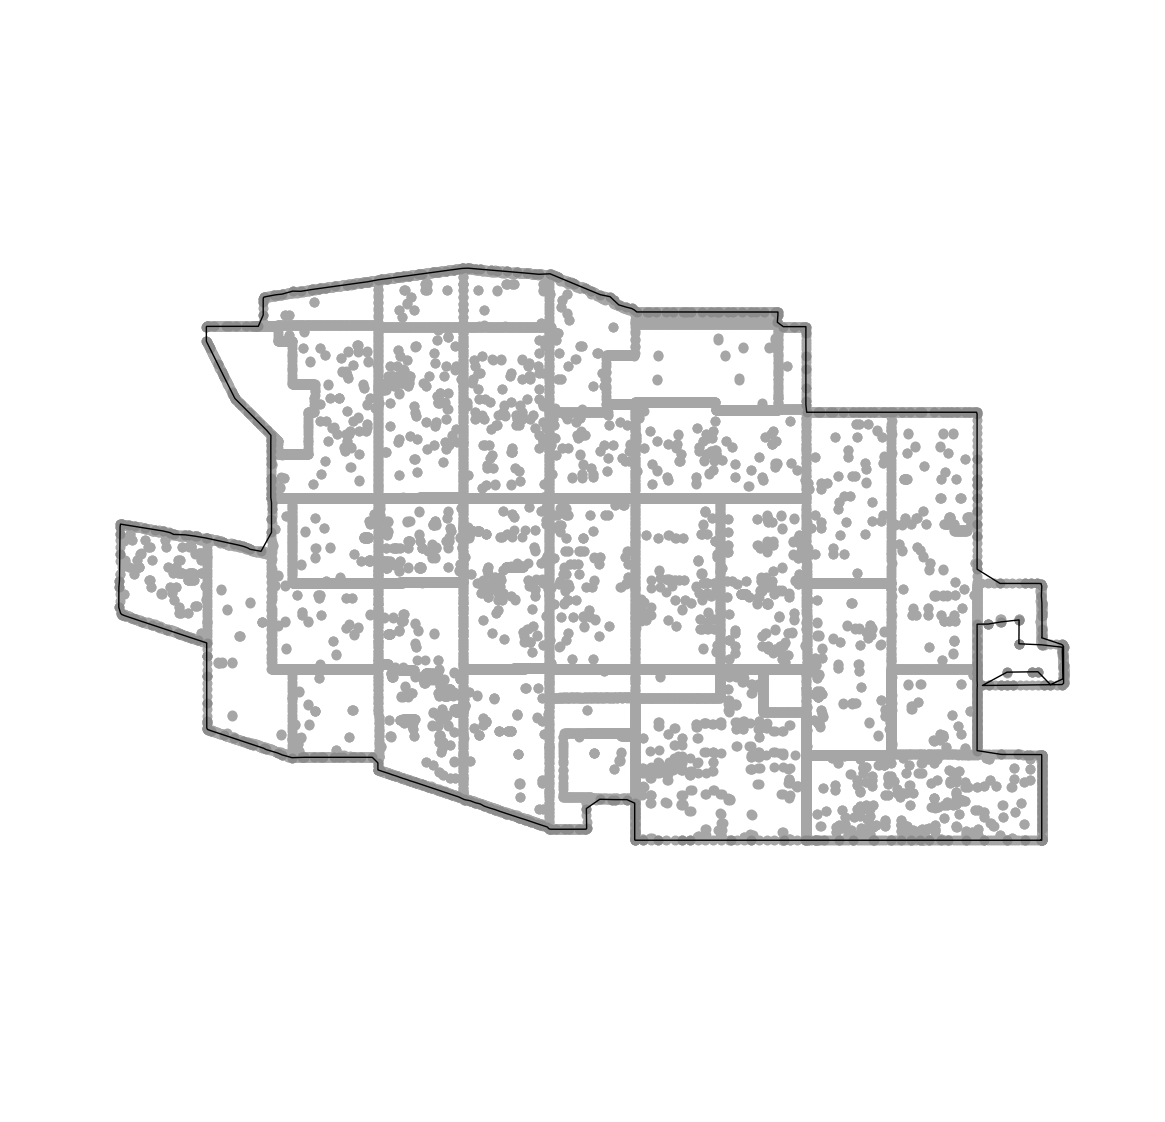

CPU times: user 4min 43s, sys: 151 ms, total: 4min 43s
Wall time: 4min 43s


In [13]:
%%time
hull = concaveHull(points, 3)
plt.figure(figsize=(20, 20))
plotPath(points, hull)

## Buffering

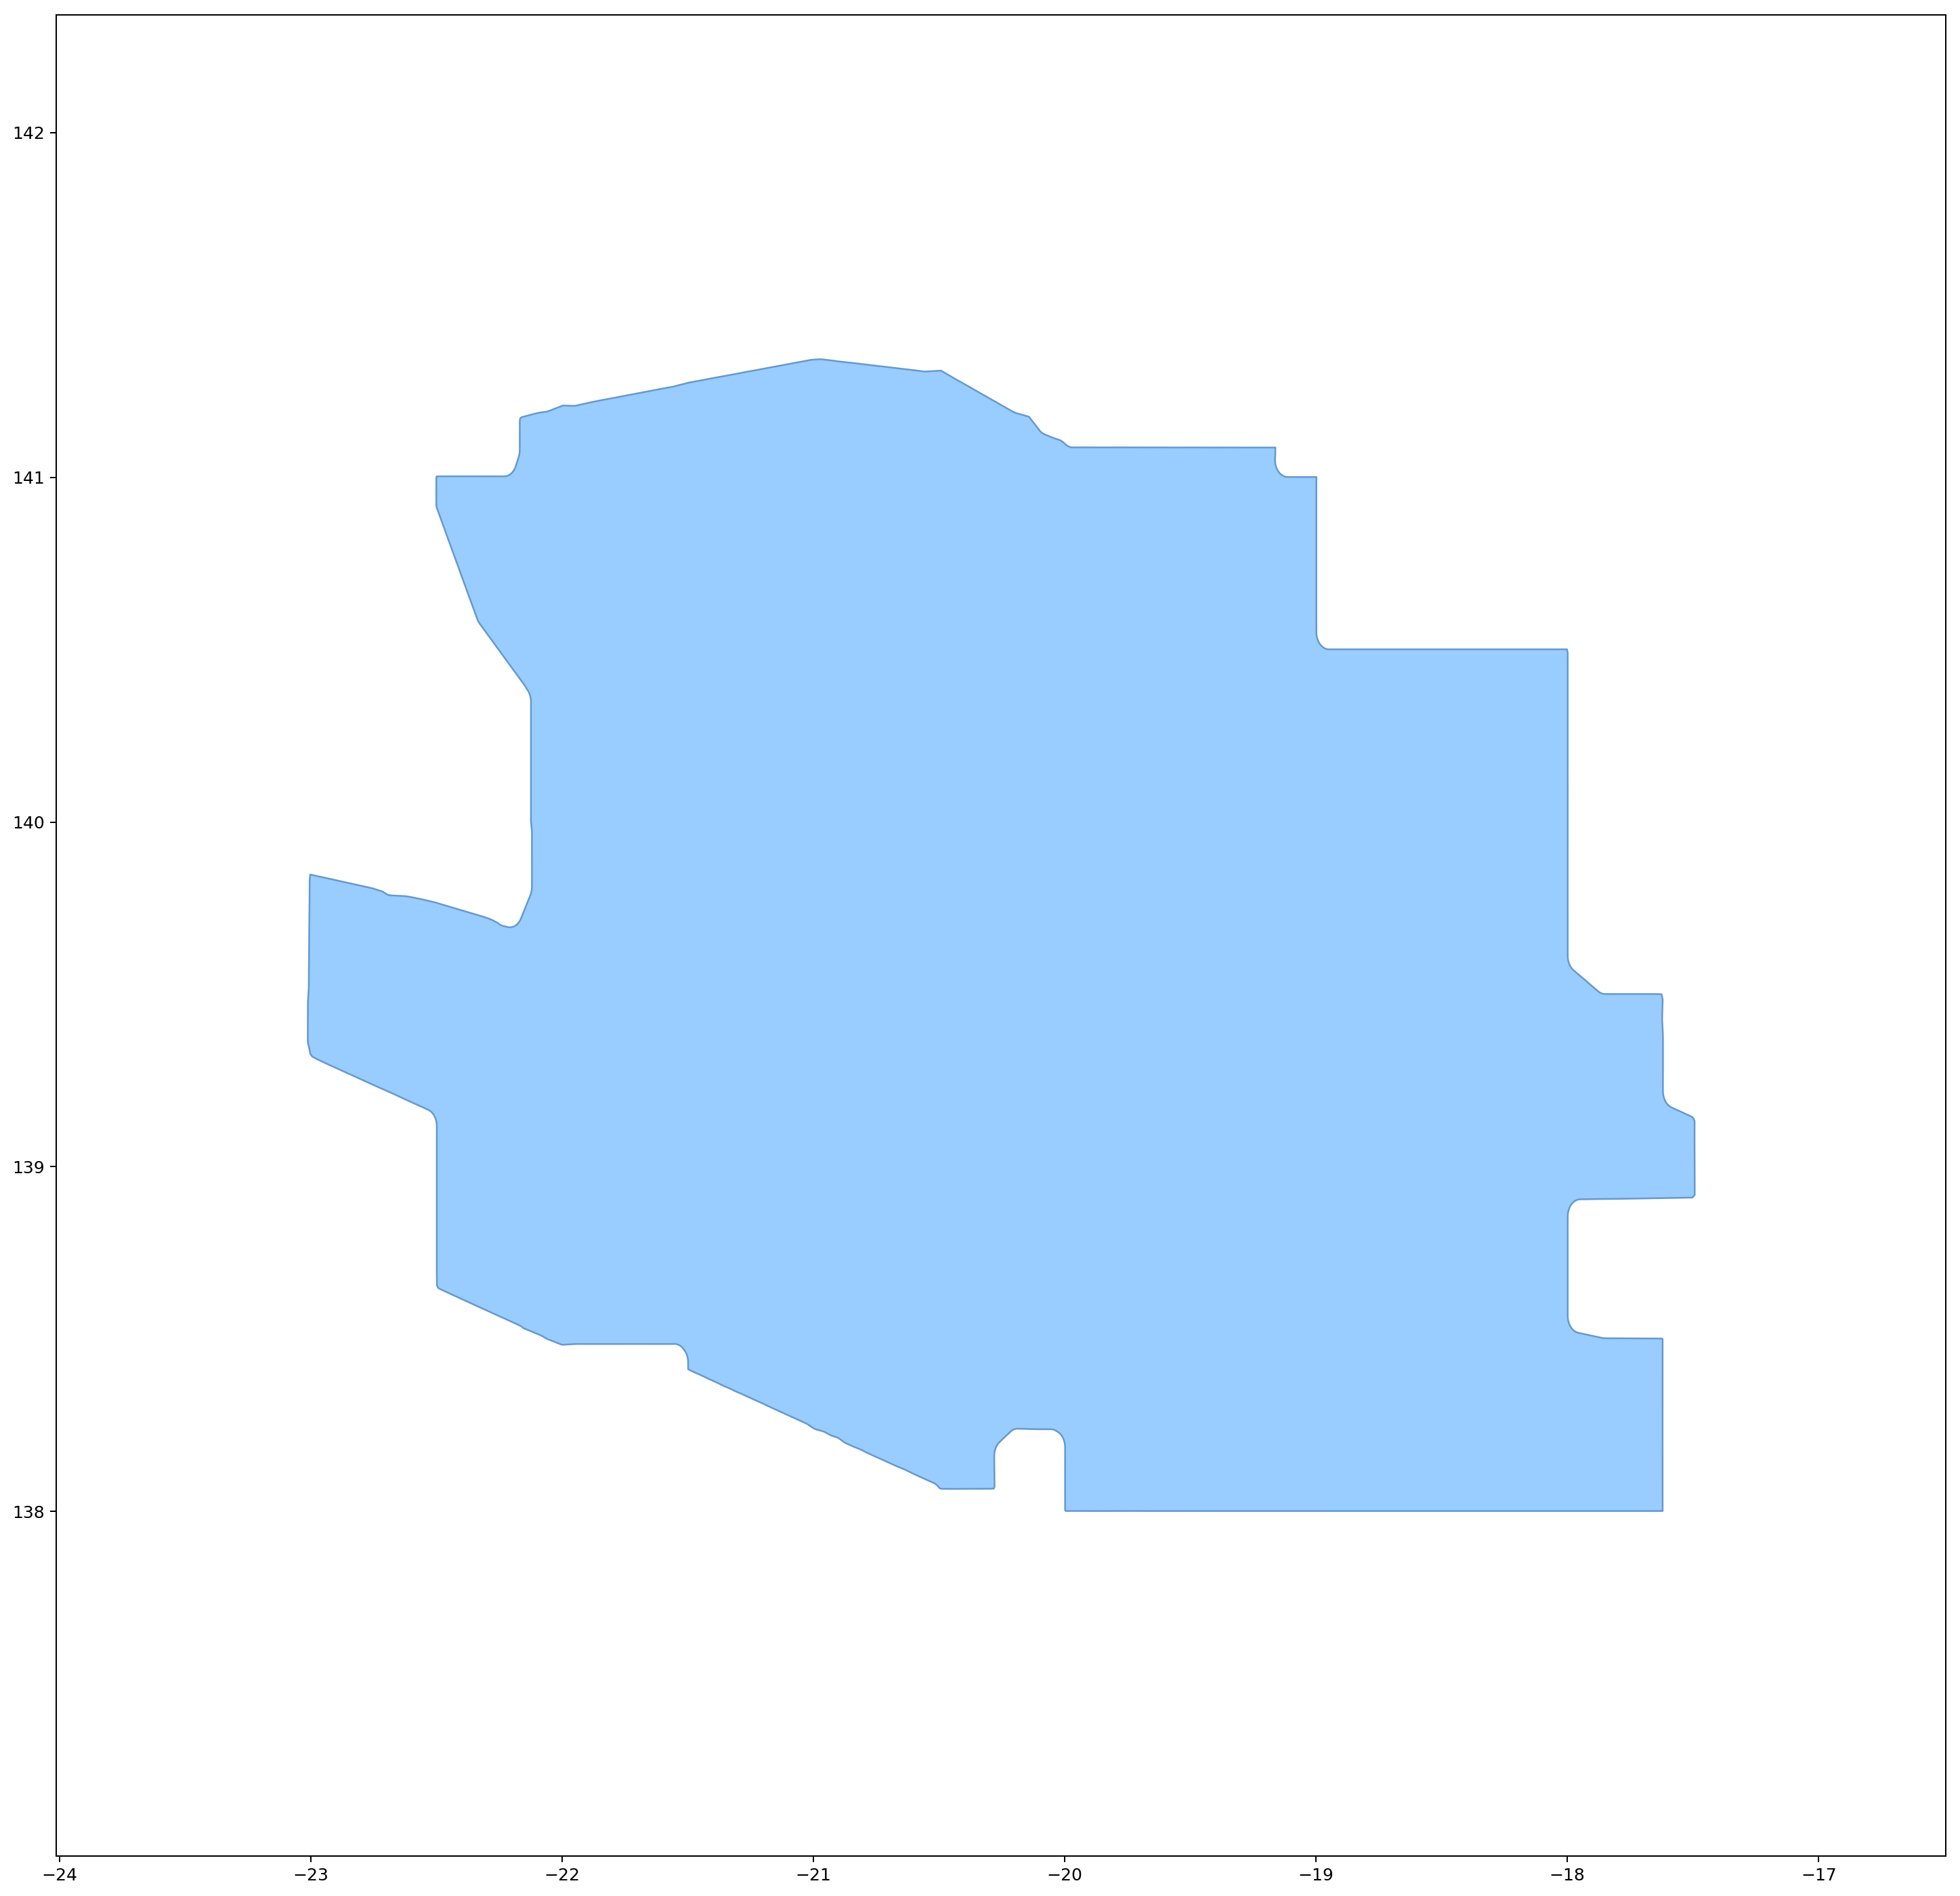

In [99]:
hull_arr = np.array(hull)

fig = pyplot.figure(figsize=(20, 20), dpi=180)
ax = fig.add_subplot(111)
# Plot 1: dilating a line
poly = geometry.Polygon(hull)
patch = PolygonPatch(poly, facecolor='#99ccff', edgecolor='#6699cc')
ax.set_xlim(np.min(hull_arr[:, 0]) - 1, np.max(hull_arr[:, 0]) + 1)
ax.set_ylim(np.min(hull_arr[:, 1]) - 1, np.max(hull_arr[:, 1]) + 1)
#ax.add_patch(patch)

dilated = geometry.Polygon(poly.buffer(0.05).exterior)
reduced = dilated.buffer(-0.05)
patch1 = PolygonPatch(reduced, facecolor='#99ccff', edgecolor='#6699cc')
ax.add_patch(patch1)
#x, y = poly.xy
#ax.plot(x, y, color='#999999')
#ax.set_xlim(-1, 4)
#ax.set_ylim(-1, 3)

# Test with a crescent

In [14]:
points = np.array([x for x in [np.random.rand(2) for i in range(1000)]
                   if norm(x - np.array([0.5, 0.5])) < 0.5 and norm(x - np.array([1.0, 1.0])) > 0.75])


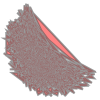

In [15]:
geometry.Polygon(points)

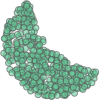

In [16]:
geometry.MultiPoint(points)

In [17]:
hull_k3 = concaveHull(points, 3)

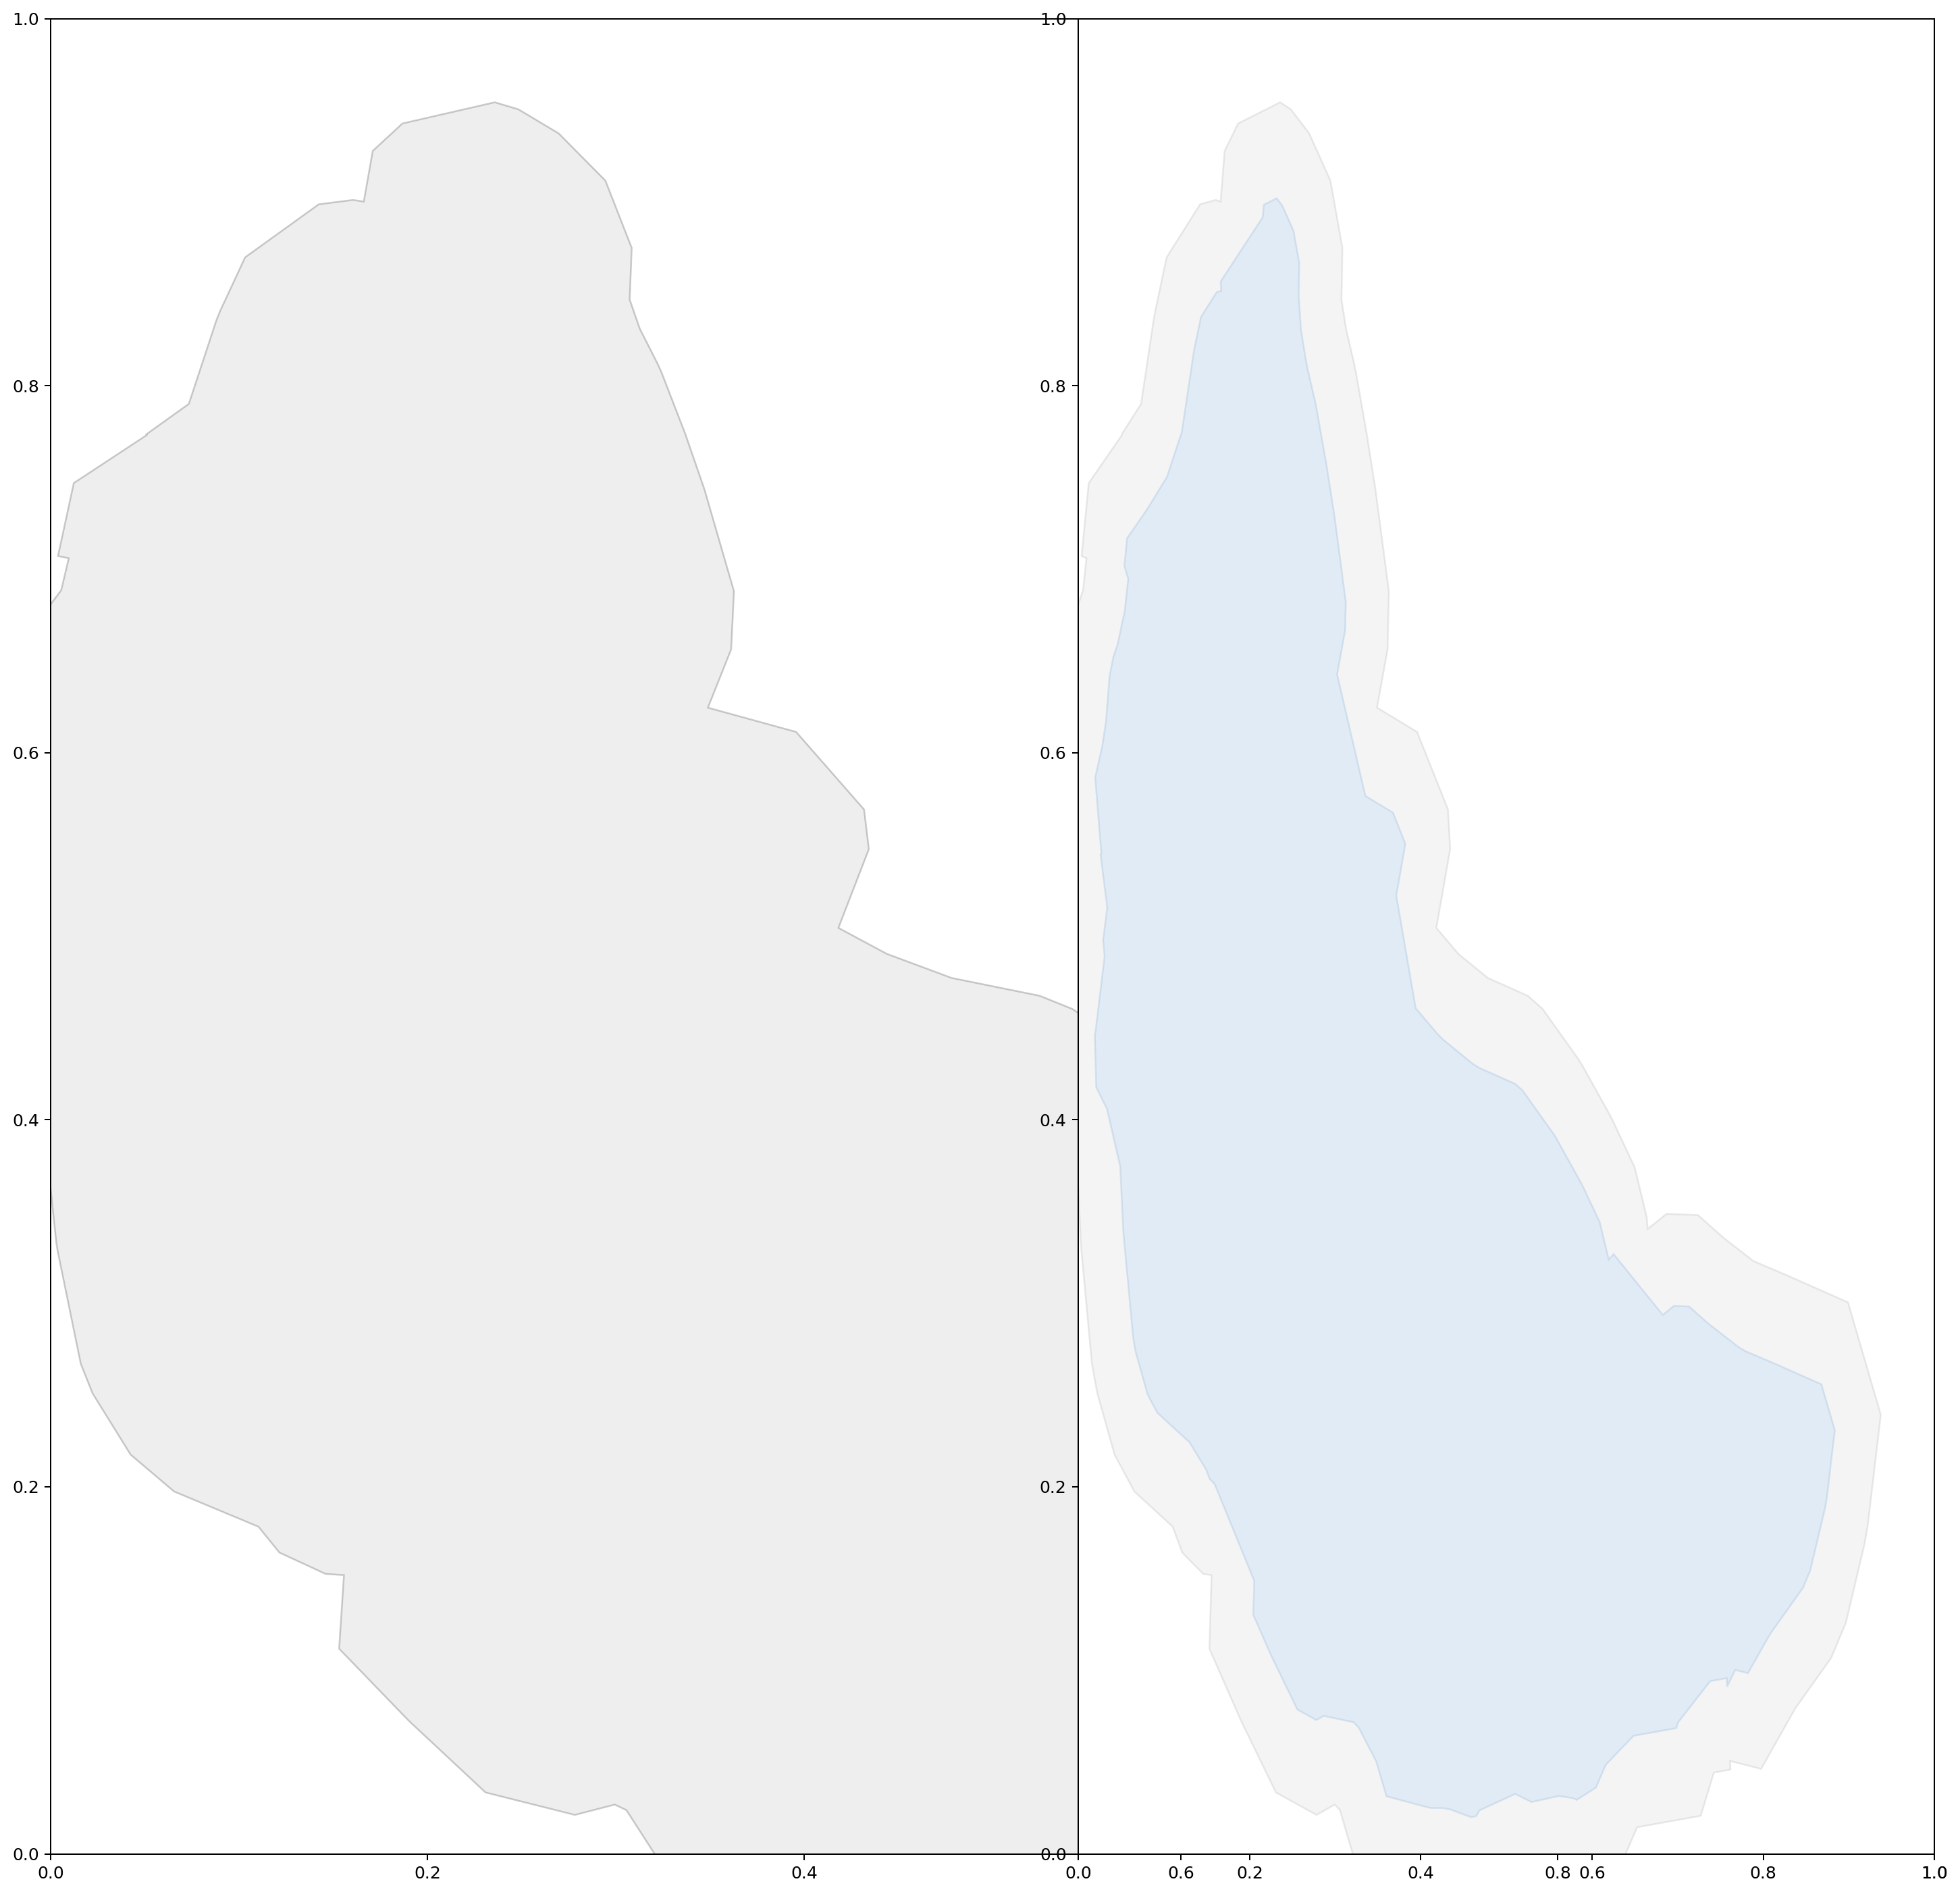

In [64]:
dilation=0.05
tolerance=0.01

poly = geometry.Polygon(hull_k3)

fig = plt.figure(1,figsize=(20,20), dpi=180)
ax = fig.add_subplot(111)

poly1 = poly.buffer(dilation, cap_style=3, join_style=3)
patch1 = ax.add_patch(PolygonPatch(poly1, fc='#AAAAAA', ec='#000000', alpha=0.1))
ax.add_patch(patch1)




eroded=-0.05
tolerance=0.01

#poly = geometry.Polygon(hull_k3)

fig = plt.figure(1,figsize=(20,20), dpi=180)
ax = fig.add_subplot(122)

poly2 = poly1.buffer(eroded, cap_style=3, join_style=3)
patch3 = ax.add_patch(PolygonPatch(poly1, fc='#cccccc', ec='#999999', alpha=0.1))
ax.add_patch(patch3)
patch2 = ax.add_patch(PolygonPatch(poly2, fc='#99ccff', ec='#6699cc', alpha=0.1))
ax.add_patch(patch2)



#test

In [19]:
from shapely import affinity
from functools import partial
import pyproj
from shapely.ops import transform

In [20]:
g1 = geometry.LineString([(0, 0), (10, 0), (10, 5), (20, 5)])

In [21]:
function = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:26913'))
g2 = transform(function, g1)